In [1]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 3.5 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1638295 sha256=aaf1d67f4349fc59fc3904664243ff1692200c85f85599be61741f92cc609260
  Stored in directory: /home/aingeru/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
You should consider upgrading via the '/home/aingeru/anaconda3/bin/python -m pip install --upgrade pip' command.


# Sistema recomendador
Se hara un sistema recomendador usando unicamente aprendizaje automatico (ninguna red neural) usando conjuntos de datos de amazon http://deepyeti.ucsd.edu/jianmo/amazon/index.html , solo las valoraciones de usuarios con productos para ser precisos. 

Se usa la biblioteca surprise (https://surprise.readthedocs.io/en/stable/index.html)  pues es extremadamente util para lidiar con datos dispersos muy comunes en sistemas recomendadores.

In [ ]:
import surprise

from surprise.prediction_algorithms.knns import KNNBasic
from surprise.model_selection import KFold, GridSearchCV
from surprise.model_selection.split import train_test_split
from surprise.model_selection.validation import cross_validate

from surprise import accuracy
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline
from surprise import KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import gzip
import json
import io
import os
import itertools
import sklearn

from sortedcontainers import SortedList
from scipy.sparse import csr_matrix
from collections import defaultdict
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity 

In [ ]:
from google.colab import files
from google.colab import drive  

drive.mount('/content/drive')

Mounted at /content/drive


# Examinando el dataset

In [ ]:
fname = 'Software.csv'
df = pd.read_csv(os.path.join('drive', 'My Drive', 'petroleo', 'amazon', fname), header=None)  

#  product_id, user_id, rating, unix_time
print(df.shape)  # reviews, atributos
df.head()

(459436, 4)


,0,1,2,3
0,0077613252,A240ORQ2LF9LUI,4.0,1394496000
1,0077613252,A1YCCU0YRLS0FE,4.0,1393113600
2,0077613252,A1BJHRQDYVAY2J,1.0,1392595200
3,0077613252,APRDVZ6QBIQXT,3.0,1392595200
4,0077775473,A2JZTTBSLS1QXV,5.0,1381708800


In [ ]:
column_names = ['item', 'user', 'rating', 'unix_time']
df.rename(columns={x: y for x, y in zip(df.columns, column_names)}, inplace=True)  # renombre sin reasignar

count_duplicates = df.duplicated(df.columns).sum()
print(f'duplicados: {count_duplicates}')

duplicados: 8653


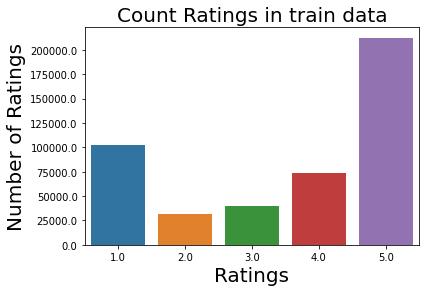

In [ ]:
# plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)
ax.set_yticklabels([num for num in ax.get_yticks()])
# plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()


# Preprocesado de el conjunto de datos
Se conservan solo los las filas y columnas que tengan al menos n elementos.

In [ ]:
def filter_by_freq(df: pd.DataFrame, column: str, min_freq: int) -> pd.DataFrame:
    """Filters the DataFrame based on the value frequency in the specified column.

    :param df: DataFrame to be filtered.
    :param column: Column name that should be frequency filtered.
    :param min_freq: Minimal value frequency for the row to be accepted.
    :return: Filter serie.
    """
    freq = df[column].value_counts()  # Frequencies of each value in the column.
    frequent_values = freq[freq >= min_freq].index  # Select frequent values. Value is in the index.
    return df[column].isin(frequent_values)  # return series filter

def label_df(df, ):
    le_user = preprocessing.LabelEncoder().fit(df_dense['user'])
    le_item = preprocessing.LabelEncoder().fit(df_dense['item'])
    df.loc[:, 'user'] = le_user.transform(df_dense['user'])
    df.loc[:, 'item'] = le_item.transform(df_dense['item'])


filter_user = filter_by_freq(df, 'user', 5)
filter_item = filter_by_freq(df, 'item', 5)
df_dense = df[filter_user & filter_item]

df_dense.shape

(24650, 4)

## Prueba de algoritmos
Se usan diversos algoritmos para ver su rendimiento en el dataset.

In [ ]:
def test_algos():
    benchmark = []
    algos = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), 
            KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]
    for algorithm in algos:
        results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
    return pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  


reader = Reader(rating_scale=(1, 5), )
# reader = Reader(rating_scale=(1, 5), line_format='item user rating')
data = Dataset.load_from_df(df_dense[['user', 'item', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)  # important step, you can't fit by using the data only

%time test_algos()

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.228389,2.853442,0.146885
SVD,1.259521,0.994424,0.057635
KNNWithMeans,1.300836,0.396948,0.261320
BaselineOnly,1.301049,0.036474,0.038243
KNNWithZScore,1.303850,0.502574,0.289879
CoClustering,1.321165,0.851564,0.041682
SlopeOne,1.327648,0.434256,0.100424
KNNBaseline,1.344652,0.409067,0.297940
NMF,1.380167,1.448330,0.073221


## KNNBasic
Filtros colaborativos.


In [ ]:

sim_options = {'name': 'pearson', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
%time algo.fit(trainset=trainset)
preds = algo.test(testset)

# metrics
mae_model = accuracy.mae(preds)
rmse_model = accuracy.rmse(preds)
print(mae_model, rmse_model)

Computing the pearson similarity matrix...
Done computing similarity matrix.
CPU times: user 627 ms, sys: 13.9 ms, total: 641 ms
Wall time: 642 ms
MAE:  1.0548
RMSE: 1.3809
1.0548027809493299 1.3808859351799894


## Baseline


In [ ]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE: 1.2811


1.2811287763187786

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_preds = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_preds['Iu'] = df_preds.uid.apply(get_Iu)
df_preds['Ui'] = df_preds.iid.apply(get_Ui)
df_preds['err'] = abs(df_preds.est - df_preds.rui)
best_predictions = df_preds.sort_values(by='err')[:10]
worst_predictions = df_preds.sort_values(by='err')[-10:]

best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2448,AYICV8N9QCSBE,B0000AZJY6,5.0,5.000000,{'was_impossible': False},4,331,0.000000
1436,A1V3PCKVCJ3TTZ,B000EORV8Q,5.0,5.000000,{'was_impossible': False},11,167,0.000000
2457,A1FR68QH6Z4YZM,B000050ZRE,5.0,5.000000,{'was_impossible': False},6,172,0.000000
3131,A1I7HLVM8OHMCF,B000EORV8Q,5.0,5.000000,{'was_impossible': False},6,167,0.000000
3695,A26LD9FQHTM8ZH,B00EZKNY8G,4.0,3.999950,{'was_impossible': False},9,15,0.000050
3778,A1IO93OKI5A23F,B0013O54P8,2.0,1.999949,{'was_impossible': False},5,30,0.000051
4200,A2FRKEXDXDN1KI,B0000DFHQ3,4.0,3.999625,{'was_impossible': False},5,1,0.000375
66,A3G7BEJJCPD6DS,B00BFNCFZ4,4.0,4.000692,{'was_impossible': False},15,17,0.000692
2192,A34VRVI4CSI5RQ,B0002D0KX2,4.0,3.999167,{'was_impossible': False},12,1,0.000833
3948,A15S4XW3CRISZ5,B00005B0C2,4.0,4.000848,{'was_impossible': False},46,2,0.000848


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4815,A1ZBYJ4ET9FZNC,B00002JV62,1.0,4.374636,{'was_impossible': False},6,1,3.374636
2633,A2FUGL44X83UV4,B00UB76290,1.0,4.399670,{'was_impossible': False},5,71,3.399670
762,A2LQRY6QU7KQY7,B009CCVMO0,1.0,4.408493,{'was_impossible': False},4,33,3.408493
3767,A9P4Q7KX35RS2,B00OW2PHF0,1.0,4.431176,{'was_impossible': False},11,17,3.431176
3763,A3C2O6SS4ITQHC,B005S4Y13K,1.0,4.435390,{'was_impossible': False},3,59,3.435390
6084,A5R1VT4MTNZKT,B00EZKNYWC,1.0,4.444749,{'was_impossible': False},4,24,3.444749
1868,A1ZQS1402K66SZ,B005S4Y65I,1.0,4.502896,{'was_impossible': False},4,25,3.502896
3089,A20ZQBUF37U01H,B00F8K9L3Y,1.0,4.537862,{'was_impossible': False},4,13,3.537862
5753,A2BKVMWLF786XU,B01617VQJ4,1.0,4.539941,{'was_impossible': False},4,49,3.539941
5831,AK8GQ08WTHW4G,B0144NYEY6,1.0,4.572268,{'was_impossible': False},2,37,3.572268


## SVD 
Matrix factorization

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
    

In [ ]:
algo = SVD()
print('Ajuste')
%time algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()
print('Predicciones')
%time predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in itertools.islice(top_n.items(), 10):
    print(uid, [iid for (iid, _) in user_ratings])

Ajuste
CPU times: user 1.21 s, sys: 3.78 ms, total: 1.21 s
Wall time: 1.22 s
Predicciones
CPU times: user 39.7 ms, sys: 5.96 ms, total: 45.7 ms
Wall time: 40.6 ms
A2DV14M0BC6YY1 ['B00KZMYZEA', 'B014SOKD9Q', 'B00VQCULBY', 'B00UBKB40Y']
A2FN62SIDTG54G ['B00EZPXOTA']
A36788MO8I0URE ['B00UB76290', 'B008XAXAC4']
AIOBOYCO1TPKR ['B0000AZJY6', 'B0001FS9NE']
A3GVJ88EHS08RZ ['B00004SC2M']
A1W41I7MW62L9R ['B00HRQB28Y', 'B005CSAE92']
A2NOJVQUPKPTEI ['B004PIPG2A']
A1ER6IYOMM8VCT ['B004DTLWZ6', 'B004PIPG2A', 'B002JB3BC2', 'B004QK8FBG', 'B003HCA7GA', 'B003ZRTDPS']
A261P36T13YP98 ['B00N4OLGP2']
A1Q0OFY99JXU43 ['B000050ZRE', 'B0000AZJY6']


In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

def test_precision_recall(algo, data):
    kf = KFold(n_splits=5)
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
    
        # Precision and recall can then be averaged over all users
        print('precision')
        print(sum(prec for prec in precisions.values()) / len(precisions))
        print('recall')
        print(sum(rec for rec in recalls.values()) / len(recalls))
        print()


%time test_precision_recall(algo, data)

precision
0.42643634522905594
recall
0.3700263290240511

precision
0.42177012364370425
recall
0.3699425448384571

precision
0.42502239283429305
recall
0.37654327757974587

precision
0.42497455470737916
recall
0.37210926795850446

precision
0.4240599593495935
recall
0.3729925012318306

CPU times: user 6.59 s, sys: 18.7 ms, total: 6.61 s
Wall time: 6.63 s


In [ ]:

param_grid = {'n_factors': [50,100,150],'n_epochs': [20,30], 'lr_all': [0.005,0.01],'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
%time gs.fit(data)
params = gs.best_params['rmse']
%time svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

CPU times: user 1min 32s, sys: 455 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 2.88 ms, sys: 5.01 ms, total: 7.89 ms
Wall time: 7.85 ms


In [ ]:
test_precision_recall(svdtuned, data)

precision
0.46472528866895063
recall
0.43395916036761095

precision
0.4644461266717134
recall
0.4274470398808019

precision
0.45607895068735027
recall
0.4233916312803939

precision
0.46800177170336626
recall
0.4345913577690343

precision
0.4615288689362765
recall
0.43270625122476974

